In [1]:
import sys
sys.path.append('../scripts/')
from dp_policy_agent import *

In [2]:
class StateInfo: ###stateinfo2
    def __init__(self, action_num):
        self.action_values = np.zeros(action_num)
        
    def best_action_index(self):
        return np.argmax(self.action_values)

In [3]:
class QAgent(PuddleIgnoreAgent): ###qagent2（20行目以降）
    def __init__(self, time_interval, particle_pose, envmap, goal, particle_num=100, \
                motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}, widths=np.array([0.2, 0.2, math.pi/18]).T, \
                lowerleft=np.array([-4, -4]).T, upperright=np.array([4, 4]).T, puddle_coef=100):   
        
        super().__init__(time_interval, particle_pose, envmap, goal, particle_num, motion_noise_stds)
        
        ###DynamicProgrammingから持ってくる###
        self.pose_min = np.r_[lowerleft, 0]
        self.pose_max = np.r_[upperright, math.pi*2]
        self.widths = widths
        self.goal = goal
        self.index_nums = ((self.pose_max - self.pose_min)/self.widths).astype(int)
        nx, ny, nt = self.index_nums
        self.indexes = list(itertools.product(range(nx), range(ny), range(nt)))
        
        self.time_interval = time_interval
        self.puddle_coef = puddle_coef
        
        ###PuddleIgnorePolicyの方策と価値関数の読み込み###
        self.actions, self.action_value_function = self.set_action_value_function()

    def set_action_value_function(self): #二つのファイルを読んで行動のリストと行動価値関数を初期化
        policy = np.zeros(np.r_[self.index_nums,2])
        for line in open("puddle_ignore_policy.txt", "r"): #方策のファイルを読み込む
            d = line.split()
            policy[int(d[0]), int(d[1]), int(d[2])] = [float(d[3]), float(d[4])]
        
        actions = list(set([tuple(policy[i]) for i in self.indexes])) #行動のリスト（前進、左回転、右回転のリストに）
        action_num = len(actions) #行動のリストの要素数
        
        q = {}
        for line in open("puddle_ignore_values.txt", "r"): #価値のファイルを読み込む
            d = line.split()
            index, value = (int(d[0]), int(d[1]), int(d[2])), float(d[3]) #インデックスをタプル、値を数字に
            q[index] = StateInfo(action_num) #StateInfoオブジェクトを割り当てて初期化
            
            for i, a in enumerate(actions): #方策の行動価値を価値のファイルに書いてある値に。そうでない場合はちょっと引く
                q[index].action_values[i] = value if tuple(policy[index]) == a else value - 0.1
                
        return actions, q
    
    def greedy_policy(self, pose): #dp_policy_agentからコピーして後半を変更
        index = np.floor((pose - self.pose_min)/self.widths).astype(int)
        
        index[2] = (index[2] + self.index_nums[2]*1000)%self.index_nums[2]
        for i in [0,1]:
            if index[i] < 0: index[i] = 0
            elif index[i] >= self.index_nums[i]: index[i] = self.index_nums[i] - 1
                
        a = self.action_value_function[tuple(index)].best_action_index() #ここからaction_value_functionを使うように書き換え
        return self.actions[a]
        
    def decision(self, observation=None): #dp_policy_agentからコピー
        nu, omega = self.greedy_policy(self.mcl.ml_pose) #greedy_policyに変更
        self.mcl.motion_update(nu, omega, self.time_interval)
        self.mcl.observation_update(observation)
        
        return nu, omega

<IPython.core.display.Javascript object>


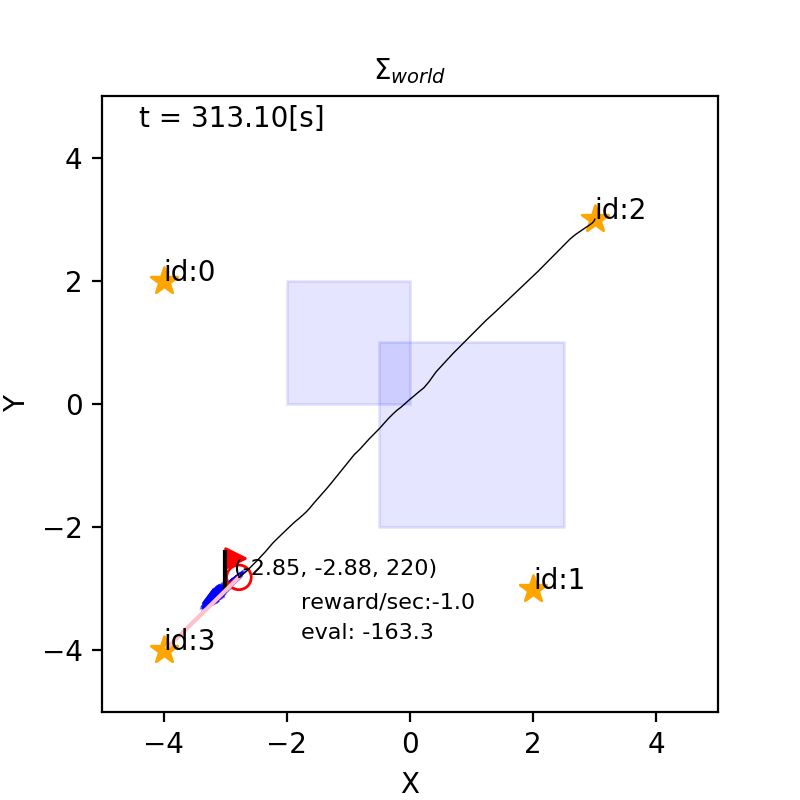

In [4]:
if __name__ == '__main__': 
    time_interval = 0.1
    world = PuddleWorld(400, time_interval)  #長めにアニメーション時間をとる

    m = Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    m.append_landmark(Landmark(-4,-4)) #追加（ゴール方向にランドマークがないので）
    world.append(m)
    
    ###ゴールの追加###
    goal = Goal(-3,-3)
    world.append(goal)
    
    ###水たまりの追加###
    world.append(Puddle((-2, 0), (0, 2), 0.1)) 
    world.append(Puddle((-0.5, -2), (2.5, 1), 0.1))

    ###ロボットを1台登場させる###
    init_pose = np.array([3, 3, 0]).T
    qa = QAgent(time_interval, init_pose, m, goal)  
    r = PuddleRobot(time_interval, init_pose, sensor=Camera(m, distance_bias_rate_stddev=0, direction_bias_stddev=0),
              agent=qa, color="red", bias_rate_stds=(0,0))

    world.append(r)
    
    world.draw()
    #r.one_step(0.1) #デバッグ時